# VGG16 Temporal Action recognition

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import transform, filter
import sys, pylab, operator, csv
import os
import urllib
import imageio
import itertools
from skimage.io import Image
from skimage.color import rgb2gray
import caffe
import transformers
caffe.set_mode_gpu()

import visualisation
import ucf101
import excitation_backprop
import util
import debug

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
model_root_path = "/home/will/nets/vgg_16_ucf101/"
model_name = "cuhk_action_temporal_vgg_16_split1"

deploy_prototxt_path = os.path.join(model_root_path, model_name + "_deploy.prototxt")
caffemodel_path = os.path.join(model_root_path, model_name + ".caffemodel")


net = caffe.Net(deploy_prototxt_path,
                caffemodel_path,
                caffe.TEST)

# The very last layer in the network (pre loss layer)
topLayerName = 'fc8'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'fc7'
secondTopBlobName = net.top_names[secondTopLayerName][0]

# This is the layer we'll stop at when excitation backpropping
outputLayerName = 'pool3'

In [4]:
debug.filter_shapes(net)

{'conv1_1': (64, 20, 3, 3),
 'conv1_2': (64, 64, 3, 3),
 'conv2_1': (128, 64, 3, 3),
 'conv2_2': (128, 128, 3, 3),
 'conv3_1': (256, 128, 3, 3),
 'conv3_2': (256, 256, 3, 3),
 'conv3_3': (256, 256, 3, 3),
 'conv4_1': (512, 256, 3, 3),
 'conv4_2': (512, 512, 3, 3),
 'conv4_3': (512, 512, 3, 3),
 'conv5_1': (512, 512, 3, 3),
 'conv5_2': (512, 512, 3, 3),
 'conv5_3': (512, 512, 3, 3),
 'fc6': (4096, 25088),
 'fc7': (4096, 4096),
 'fc8': (101, 4096)}

In [10]:
data_root = "/home/will/thesis/generated/ucf101/test-1/flow/"
video_name = "v_Basketball_g05_c04"

start_frame_index = 17
stop_frame_index = start_frame_index + 10
#image_path = os.path.join(data_root, "desk-plug-plug/frame000084.jpg")¬
#image_path = os.path.join(data_root, "treadmill-press-button/frame000034.jpg")
#image_path = os.path.join(data_root, "printer-press-button/frame000010.jpg")
#image_path = os.path.join(data_root, "push_drawer/frame000057.jpg")
#image_path = os.path.join(data_root, "insert_screwdriver/frame000135.jpg")
u_frames = [os.path.join(data_root, "u", video_name, "frame{:06d}.jpg".format(frame_index)) for frame_index in range(start_frame_index, stop_frame_index)]
v_frames = [os.path.join(data_root, "v", video_name, "frame{:06d}.jpg".format(frame_index)) for frame_index in range(start_frame_index, stop_frame_index)]
underlay = rgb2gray(caffe.io.load_image(os.path.join(data_root, '..', 'frames', video_name, "frame{:06d}.jpg".format(start_frame_index))))
image_paths = list(itertools.chain(*zip(u_frames, v_frames)))

new_size = (224,224)
transformer = transformers.flow_transformer(net)
images = [caffe.io.load_image(image_path, color=False) for image_path in image_paths]
preprocessed_flow = np.array([transformer.preprocess('data', frame) for frame in images])
optical_flow_gif = video_name + ".gif"
imageio.mimsave(optical_flow_gif, images)
from IPython.display import HTML
HTML("<img src=\"{}\" />".format(optical_flow_gif))

/usr/local/lib/python3.5/dist-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [11]:
pathological_examples_root = "/home/will/thesis/pathological-inputs/"
black = caffe.io.load_image(os.path.join(pathological_examples_root, "black.png"), color=False)
left_bottom = caffe.io.load_image(os.path.join(pathological_examples_root, "bottom-left.png"), color=False)
left_mid = caffe.io.load_image(os.path.join(pathological_examples_root, "mid-left.png"), color=False)
left_top = caffe.io.load_image(os.path.join(pathological_examples_root, "top-left.png"), color=False)

u_frames = [left_mid] + [black]*9
v_frames = [black]*10
images = np.array(list(itertools.chain(*zip(u_frames, v_frames))))
images.shape
#Image(images[0, :, :])

(20, 224, 224, 1)

In [7]:
debug.filter_shapes(net)

{'conv1_1': (64, 20, 3, 3),
 'conv1_2': (64, 64, 3, 3),
 'conv2_1': (128, 64, 3, 3),
 'conv2_2': (128, 128, 3, 3),
 'conv3_1': (256, 128, 3, 3),
 'conv3_2': (256, 256, 3, 3),
 'conv3_3': (256, 256, 3, 3),
 'conv4_1': (512, 256, 3, 3),
 'conv4_2': (512, 512, 3, 3),
 'conv4_3': (512, 512, 3, 3),
 'conv5_1': (512, 512, 3, 3),
 'conv5_2': (512, 512, 3, 3),
 'conv5_3': (512, 512, 3, 3),
 'fc6': (4096, 25088),
 'fc7': (4096, 4096),
 'fc8': (101, 4096)}

In [12]:
eb = excitation_backprop.ExcitationBackprop(net, 'fc8', 'fc7', 'pool2')
net.blobs['data'].data[...] = preprocessed_flow.reshape(1, 20, *new_size)
out = net.forward(end = topLayerName)

class_count = 101
scores = net.blobs[eb.top_blob_name].data[0].reshape(class_count, -1).max(1).flatten() # pre-softmax scores
class_ids = scores.argsort()[-3:][::-1]

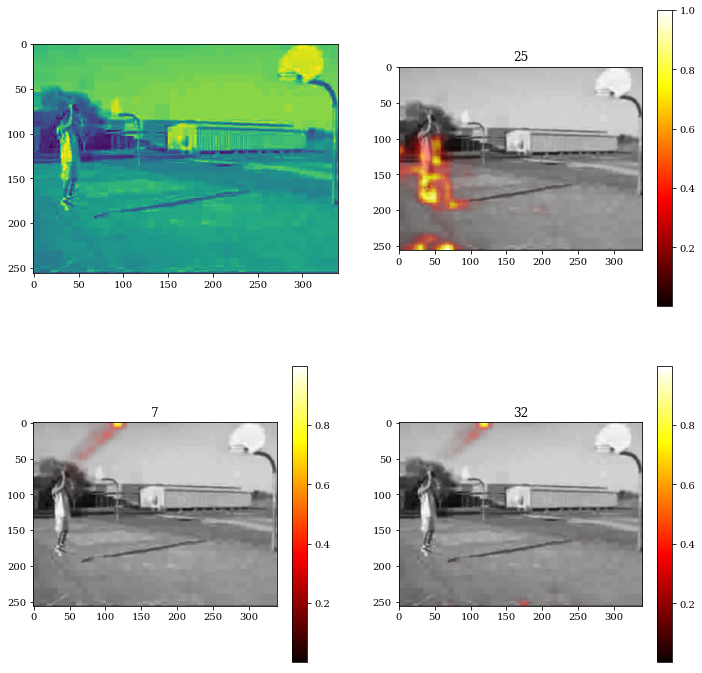

In [13]:
attMaps = []

for class_id in class_ids:
    attMap = eb.backprop(class_id)
    attMaps.append(attMap)
util.showAttMap(underlay, attMaps, class_ids, overlap=True, cmap='hot')

In [15]:
def underlay_for_index(index):
    return rgb2gray(caffe.io.load_image(
        os.path.join(data_root, '..', 'frames',  
                     video_name, "frame{:06d}.jpg".format(index))))
underlay_start = underlay_for_index(start_frame_index)
underlay_middle = underlay_for_index(int((start_frame_index + stop_frame_index) / 2))
underlay_end = underlay_for_index(stop_frame_index)

In [22]:
ucf101.labeller(video_name)

7

In [24]:
class_ids[1]

7

In [25]:
correct_class_attention_map = attMaps[1]

In [29]:
from scipy.misc import toimage

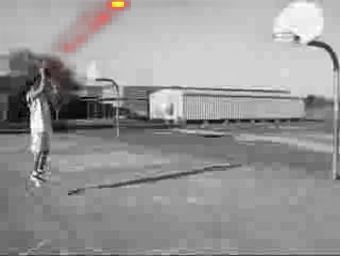

In [30]:
toimage(visualisation.overlay_attention_map(underlay_start, correct_class_attention_map))

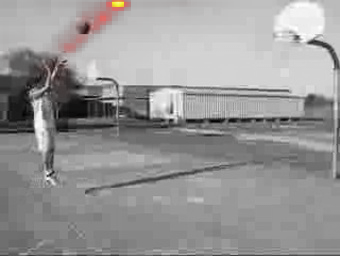

In [31]:
toimage(visualisation.overlay_attention_map(underlay_middle, correct_class_attention_map))

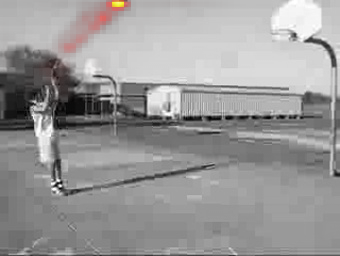

In [32]:
toimage(visualisation.overlay_attention_map(underlay_end, correct_class_attention_map))

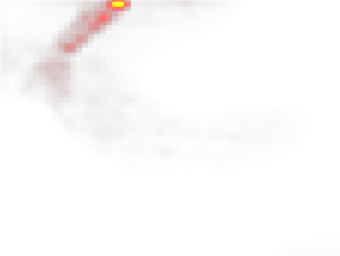

In [46]:

cmap = plt.get_cmap('hot')
toimage(visualisation.overlay_attention_map(np.ones((256, 340, 3)), correct_class_attention_map))